## Topic classifier using BERT

Development for a practice topic classifier on column (gpt_topic) using DistillBERT with head and tail tokens long-doc policy.

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from dotenv import load_dotenv
import os
import transformers
load_dotenv()  # looks for .env in current directory or parent
print(torch.__version__)
print(torch.cuda.is_available())


c:\Users\rhrou\miniconda3\envs\torch-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.1
True


#### Sample a dataset via query + tokenize

In [3]:
# Connect to server 
import psycopg2
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cur = conn.cursor()

# Do our join in database
cur.execute(f"""
           SELECT gpt_topic,
           b.maintext
           FROM mm_framing_full a
           JOIN newsarticles b ON a.url = b.url
           ORDER BY RANDOM()
            LIMIT 30000
            """)

result= cur.fetchall()

print(cur.description)

cur.close()
conn.close()

df = pd.DataFrame(result, columns=["gpt_topic", "article_text"])
df.head()

del result

(Column(name='gpt_topic', type_code=25), Column(name='maintext', type_code=25))


In [4]:
## ESSENTIAL DATA FILTERING
# REMOVE rows that have less than 10 observations for the topic

counts = df.groupby('gpt_topic')['gpt_topic'].transform('count')

# 2. Filter the DataFrame
df_filtered = df[counts >= 10].copy()

# 3. Check the result
print(f"Original rows: {len(df)}")
print(f"Filtered rows: {len(df_filtered)}")
print(f"Topics removed: {df['gpt_topic'].nunique() - df_filtered['gpt_topic'].nunique()}")
df = df_filtered

del df_filtered, counts

Original rows: 30000
Filtered rows: 29556
Topics removed: 70


In [5]:
from transformers import AutoTokenizer, DistilBertTokenizer

# choosing a base tokenizer model, this won't 
model = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model)

test_text = "I'm a big blue watermelon"

encoded_input = tokenizer(test_text)
print(encoded_input)

# generally want to keep the tokenizations in a separate variable rather than adding them back to the dataframe (for efficiency, taking advantage of the batching features of the huggingface tokenizer)

encodings = tokenizer(df['article_text'].tolist(),                      # we opt to dynamically do padding later with head/tail strategy
                      # hence we also don't need truncation here
                      )

{'input_ids': [101, 1045, 1005, 1049, 1037, 2502, 2630, 2300, 10199, 2239, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors


In [ ]:

df['gpt_topic'].nunique()


### Implement head/tail cutting strategy to mesh into 512 token limit

Go for a balance of head - 320, and tail - 190 to balance beginning and ending article context

In [7]:
import statistics as stat

# Firstly, how many are we gonna change
lengths = [len(encoding) for encoding in encodings['input_ids']]
print(stat.mean(lengths))

exceed_count = len(list(filter(lambda l: l > 512, lengths)))
print(exceed_count)

# How many are super short? out of curiosity
short_count = len(list(filter(lambda l: l < 150, lengths)))
print(short_count)

print(len(encodings['input_ids']))


540.1154080389769
13760
7453
29556


In [12]:
head_len = 320
tail_len = 190
content_len = head_len + tail_len          
max_len = content_len + 2  # [CLS] + [SEP]      

cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

for i, ids in enumerate(encodings["input_ids"]):
    # ClS and Sep Id's are present in tokenized values, so do this
    if len(ids) >= 2 and ids[0] == cls_id and ids[-1] == sep_id:
        ids = ids[1:-1]

    # Head+tail on the content tokens
    if len(ids) > content_len:
        head = ids[:head_len]
        tail = ids[-tail_len:]
        ids = head + tail

    # Add specials back
    ids = [cls_id] + ids + [sep_id]

    # Build attention mask (1 for real tokens)
    mask = [1] * len(ids)

    # Pad (or truncate)
    if len(ids) < max_len:
        pad_n = max_len - len(ids)
        ids = ids + [pad_id] * pad_n
        mask = mask + [0] * pad_n
    else:
        ids = ids[:max_len]
        mask = mask[:max_len]

    # Write back
    encodings["input_ids"][i] = ids
    encodings["attention_mask"][i] = mask

# quick sanity check
for ids, mask in zip(encodings["input_ids"][:10], encodings["attention_mask"][:10]):
    assert len(ids) == 512 and len(mask) == 512
    print(ids[:3], sum(mask))

[101, 3516, 2038] 512
[101, 4078, 23286] 512
[101, 2047, 29337] 512
[101, 2698, 4249] 111
[101, 6278, 1006] 512
[101, 6498, 6467] 125
[101, 2047, 29337] 436
[101, 2899, 1517] 512
[101, 2047, 29337] 367
[101, 2047, 29337] 512


### PyTorch Dataset Creation

Using `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`

[Pytorch data tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [13]:
# We first have to convert our label in the df into a categorical so it processes correctly
df['topic_cat'] = df['gpt_topic'].astype('category')
label_ids = df['topic_cat'].cat.codes
id_to_label = list(df['topic_cat'].cat.categories)
label_to_id = {label: i for i, label in enumerate(id_to_label)}

# so label_ids is our list of integer representations of our original topic labels

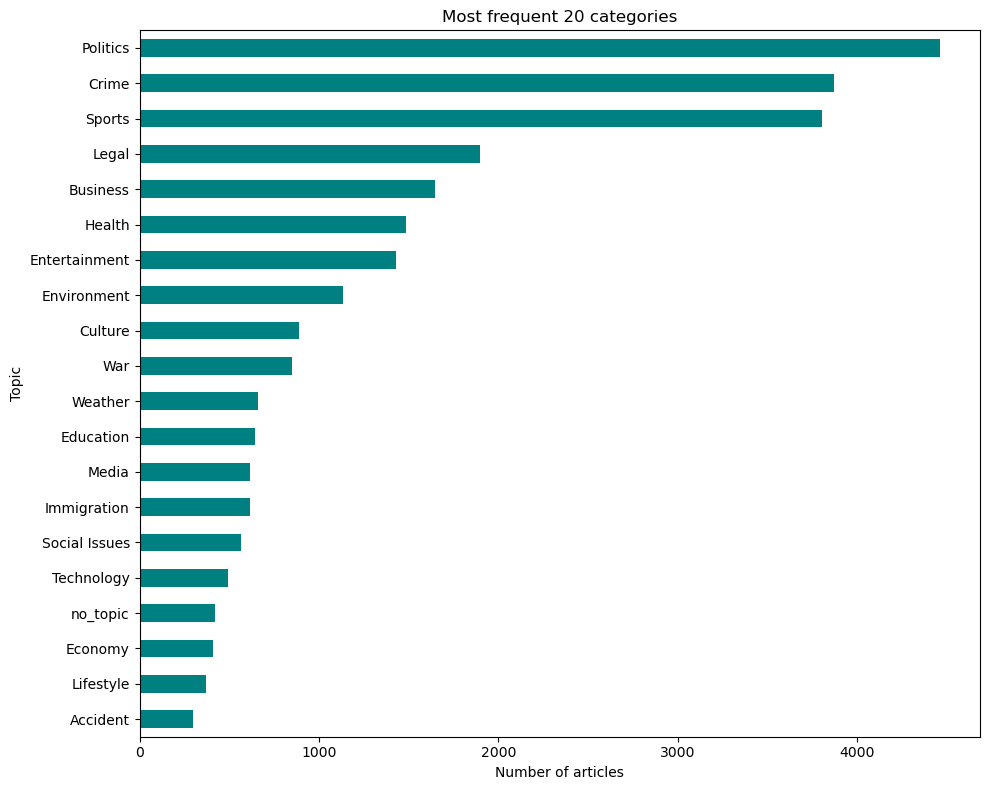

In [14]:
# Examine distribution of value counts of labels
df['topic_cat'].value_counts

import matplotlib.pyplot as plt

# 1. Calculate counts and take the top 20
top_topics = df['topic_cat'].value_counts().head(20)

# 2. Create a horizontal bar chart
# We sort_values() at the end so the highest count is at the top of the chart
top_topics.sort_values().plot(kind='barh', figsize=(10, 8), color='teal')

plt.title('Most frequent 20 categories') # "The 20 most frequent categories"
plt.xlabel('Number of articles') # "Number of articles"
plt.ylabel('Topic')
plt.tight_layout()

plt.savefig('plots/topic_distribution.png')

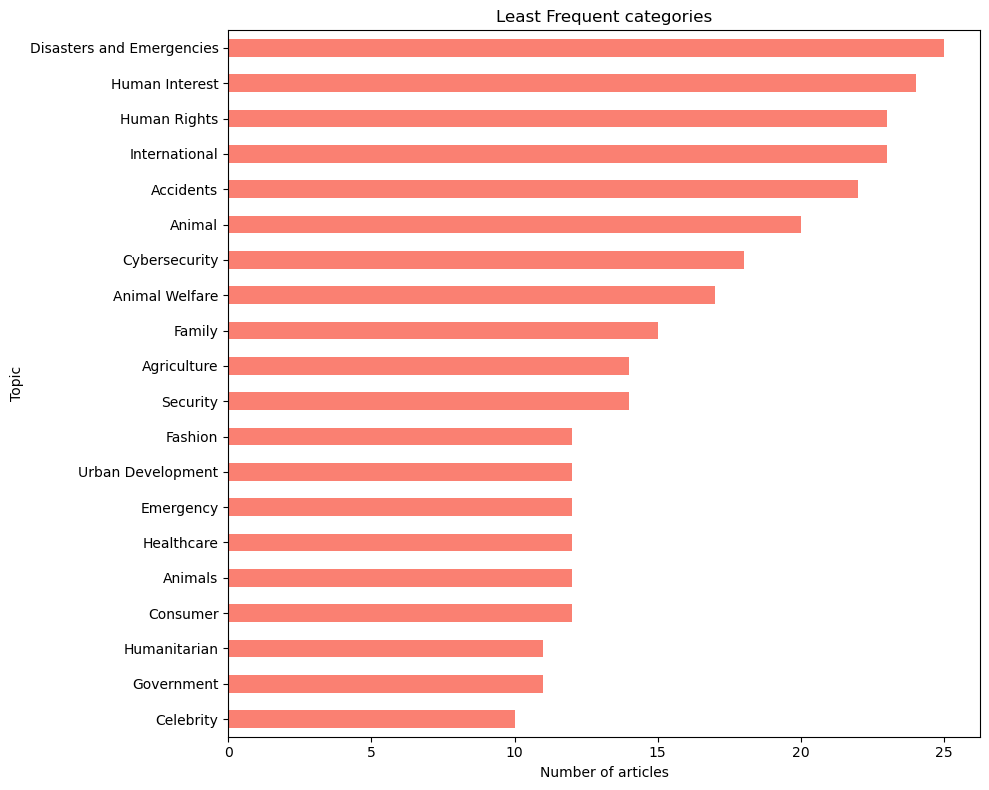

In [15]:
# 1. Get the 20 least frequent categories
# .value_counts() sorts by descending order by default, so .tail(20) gets the smallest
bottom_topics = df['topic_cat'].value_counts().tail(20)

# 2. Create the horizontal bar chart
# We sort them so the smallest bars are at the top for better readability
bottom_topics.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8), color='salmon')

plt.title('Least Frequent categories') # The 20 least frequent categories
plt.xlabel('Number of articles')
plt.ylabel('Topic')
plt.tight_layout()

plt.savefig('plots/least_frequent_topics.png')

In [92]:
from torch.utils.data import Dataset

class NewsArticleDataset(Dataset):
    def __init__(self, encodings, label_ids: pd.Series):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = label_ids.to_list() # convert to list for indexing robustness  
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        # for transformer style training, generally return a dict with keys that match what your model expects
        dict_to_return = {'input_ids': torch.tensor(self.input_ids[idx], dtype = torch.long), # convert to tensors, 64-bit integer (long) dtype 
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype = torch.long),
            'labels': torch.tensor(self.labels[idx], dtype =torch.long)}
        return dict_to_return
        


### Creating the test/train/val split

Since we have so many unique classes (100+) it seems best to stratify our data split to balance class distributions.

Can use `sklearn.model_selection.train_test_split`

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# integer-coded labels aligned with encodings order
labels = np.array(label_ids, dtype=np.int64) # numpy array

N = len(labels)
idx = np.arange(N)

# 80/10/10 split (train/val/test), stratified
train_idx, temp_idx = train_test_split(
    idx,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=labels # as array
)

# Run it again on the temp test set to get the val set
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,                    # half of 20% -> 10% val, 10% test
    random_state=42,
    shuffle=True,
    stratify=labels[temp_idx]
)

# Build ONE dataset, then slice with Subset
full_df = NewsArticleDataset(encodings, label_ids)  # or NewsArticleDataset(encodings, labels)
train = Subset(full_df, train_idx) # basically does what it says on the tin
val   = Subset(full_df, val_idx)
test  = Subset(full_df, test_idx)

print(len(train), len(val), len(test))



23644 2956 2956


### Creating the data loader

Knobs start appearing to be tweaked here, large number of options

In [18]:
# sanity check the get item method on data set class
full_df.__getitem__(2)

{'input_ids': tensor([  101,  2047, 29337,  2064,  2085,  4952,  2000,  4419,  2739,  4790,
           999,  2047,  2259,  2610,  4727,  1037,  2158,  9317,  1999,  4434,
          2000,  1037,  2186,  1997, 21690,  2015,  2008,  5229,  2012,  2560,
          2274,  2111,  1999,  8603,  2144,  2197,  2733,  1010,  1996,  6396,
         17299,  2056,  1012,  4614,  2056,  2676,  1011,  2095,  1011,  2214,
         15333, 17830,  2378, 19838,  5657,  3126,  2003,  2108,  5338,  1999,
          2176,  1997,  1996,  2274,  4491,  2061,  2521,  1012,  2002,  5344,
          5571,  1997,  4692,  4028,  1010,  6101,  1010,  4692,  6101,  1998,
          4735,  6664,  1997,  1037,  5195,  1010,  4419,  1019,  2047,  2259,
          2988,  1012,  5694,  1997,  1996, 21690,  4491,  2421,  2176,  2273,
          1998,  2028,  2450,  1010,  2035,  1997,  3183,  4265,  2512,  1011,
          2166,  1011,  8701,  6441,  1012,  1996,  2450,  2003,  4090,  2096,
          1996,  2273,  1005,  1055,  5

In [65]:
# Creating the data loader 
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          num_workers=0, # increase this later on
                          shuffle = True, 
                          pin_memory= True)
val_loader = DataLoader(val, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False, # false so eval is deterministic and reproducible
                          pin_memory= True)
test_loader = DataLoader(test, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False,  # false, as above
                          pin_memory= True)


In [ ]:
# Another sanity check, confirming shapes match expectations

# grab a batch using iterator next()
batch = next(iter(train_loader))

batch['input_ids'].shape, batch['attention_mask'].shape, batch['labels'].shape

# 32 (batch_size) X (number of tokens) = like a spreadsheet with all our tokens and 32 examples


(torch.Size([32, 512]), torch.Size([32, 512]), torch.Size([32]))

In [82]:
# Also quickly check dtypes
batch["input_ids"].dtype, batch["attention_mask"].dtype, batch["labels"].dtype


(torch.int64, torch.int64, torch.int64)

### Load Model and set device

In [20]:
# To avoid writing a head we can load it manually
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=67)
model.to('cuda')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [97]:
# Run through a mini one-example batch of what the model is actually doing and examine outputs, loss, logits, 

import torch

batch = next(iter(train_loader))
batch = {k: v.to("cuda") for k, v in batch.items()}

model.eval()
with torch.no_grad(): # do no grad so we don't build up memory on the GPU accidently
    outputs = model(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        labels=batch["labels"],
    )
    loss = outputs.loss
    logits = outputs.logits

print(loss.item())

logits = outputs.logits  # shape: (batch_size, num_labels)

outputs


4.242618083953857


SequenceClassifierOutput(loss=tensor(4.2426, device='cuda:0'), logits=tensor([[ 0.0241, -0.2661, -0.1002,  ...,  0.0505,  0.1757,  0.1081],
        [ 0.1202, -0.2232, -0.0905,  ...,  0.0015,  0.0997,  0.0538],
        [ 0.1197, -0.1909, -0.0733,  ...,  0.0992,  0.1229,  0.0738],
        ...,
        [ 0.0788, -0.1924, -0.1014,  ...,  0.0748,  0.1396,  0.0869],
        [ 0.1223, -0.1840, -0.0992,  ...,  0.0509,  0.1195,  0.0511],
        [ 0.1330, -0.2221, -0.0887,  ...,  0.0432,  0.1144,  0.0839]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [ ]:
# clearing memory
del outputs, logits, loss, batch
torch.cuda.empty_cache()


In [21]:
# checking memory usage by cuda
torch.cuda.memory_summary()


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 262848 KiB | 262848 KiB | 262848 KiB |      0 B   |\n|       from large pool | 262400 KiB | 262400 KiB | 262400 KiB |      0 B   |\n|       from small pool |    448 KiB |    448 KiB |    448 KiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         | 262848 KiB | 262848 KiB | 262848 KiB |      0 B   |\n|       from large pool | 262400 KiB | 262400 KiB |

### Setting Loss and Optimizer before training

Define optimizer as AdamW (a fine choice for now)
Set an LR scheduler or define manually, setting a value

In [22]:
# set optimizer  and LR
optimizer = torch.optim.AdamW(lr=2e-5, # for transformers, we want a low learning rate, even lower than 0.001
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize

### Training

We use the same structure as in a linear regression torch training loop but we instead, with transformers, train over batches from the DataLoader, moving each batch to the GPU, and the model can compute loss internally when you pass "labels" object.


In [23]:
# for a clean state, hard reset the GPU state
import torch, gc
gc.collect()
torch.cuda.empty_cache() 

In [ ]:
epochs = 50

# for epoch in range(epochs):
#     model.train()

#     running_loss = 0.0

#     for batch in train_loader:
#         # 1) move batch to GPU
#         batch = {k: v.to("cuda") for k, v in batch.items()}

#         # 2) forward pass 
#         outputs = model(
#             input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             labels=batch["labels"] # had a rough comma here b4
#         )

#         loss = outputs.loss # default loss from the HF auto model, likely cross entropy
#         running_loss += loss.item()

#         # 3) zero grad
#         optimizer.zero_grad()

#         # 4) backward
#         loss.backward()

#         # 5) step
#         optimizer.step()

#     # ---- validation ----
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             batch = {k: v.to("cuda") for k, v in batch.items()}
#             outputs = model(
#                 input_ids=batch["input_ids"],
#                 attention_mask=batch["attention_mask"],
#                 labels=batch["labels"],
#             )
#             val_loss += outputs.loss.item()

#             logits = outputs.logits
#             preds = logits.argmax(dim=-1)
#             correct += (preds == batch["labels"]).sum().item()
#             total += batch["labels"].size(0)

#     print(
#         f"Epoch {epoch} | train_loss={running_loss/len(train_loader):.4f} "
#         f"| val_loss={val_loss/len(val_loader):.4f} | val_acc={correct/total:.4f}"
#     )


Epoch 0 | train_loss=0.4937 | val_loss=1.2115 | val_acc=0.6827
Epoch 1 | train_loss=0.3449 | val_loss=1.3370 | val_acc=0.6759
Epoch 2 | train_loss=0.2466 | val_loss=1.6169 | val_acc=0.6641
Epoch 3 | train_loss=0.1818 | val_loss=1.6091 | val_acc=0.6769
Epoch 4 | train_loss=0.1390 | val_loss=1.7907 | val_acc=0.6658
Epoch 5 | train_loss=0.1107 | val_loss=1.8534 | val_acc=0.6698
Epoch 6 | train_loss=0.0827 | val_loss=2.0040 | val_acc=0.6793
Epoch 7 | train_loss=0.0712 | val_loss=2.0231 | val_acc=0.6610
Epoch 8 | train_loss=0.0662 | val_loss=2.0309 | val_acc=0.6722
Epoch 9 | train_loss=0.0555 | val_loss=2.0888 | val_acc=0.6620
Epoch 10 | train_loss=0.0528 | val_loss=2.1094 | val_acc=0.6752
Epoch 11 | train_loss=0.0465 | val_loss=2.1193 | val_acc=0.6627
Epoch 12 | train_loss=0.0436 | val_loss=2.1535 | val_acc=0.6752
Epoch 13 | train_loss=0.0430 | val_loss=2.1088 | val_acc=0.6759
Epoch 14 | train_loss=0.0400 | val_loss=2.1426 | val_acc=0.6705
Epoch 15 | train_loss=0.0386 | val_loss=2.2719 | v

### Evaluating and re-adjusting model approach

Seems like training is failing silently given that validation accuracy maxes out at epoch 0, a major risk specified in karpathy's recipe for training NNs. I should assume either overfitting or a pipeline/data issue until proven otherwise. To do this, we should build some paranoia checks.

#### Paranoia check 1: "set up the full skeleton + get dumb baselines"
Find out
* Majority-class accuracy
* Random baseline
* "input-independent baseline"

Having re-checked the code, I don't believe it is a mis-labelling issue- label_ids match up with encodings via index. 

In [27]:
df.describe()
# we correctly specified 67 unique labels

,gpt_topic,article_text,topic_cat
count,29556,29556,29556
unique,67,28904,67
top,Politics,BALTIMORE-- After a cloudy and mild Friday acr...,Politics
freq,4461,18,4461


In [28]:
for i in range(5):
    print(df['article_text'][i])
    print(df['gpt_topic'][i])
    
# these labels make sense

Florida has told school superintendents that the Advanced Placement psychology course offered to high school students violates the state’s new law prohibiting instruction on sexual orientation and gender identity, effectively banning the class, the non-profit that develops the courses said on Thursday.
The move is the latest by the administration of Ron DeSantis, the Republican governor, to limit instruction about LGBTQ+ issues and race in the state. DeSantis is challenging Donald Trump for the Republican nomination for president in 2024 and has made battles over cultural issues a centerpiece of his campaign.
Florida earlier this year banned a new AP African American studies course, saying it lacked “educational value and historical accuracy” and violated state law on how race can be taught in public classrooms.
While Florida officials said the psychology curriculum could still be presented if modified to comply with the law, the College Board, which develops AP classes, recommended th

In [47]:
n_topics = 8
print(f"top {n_topics} most frequent classes proportion")
print(sum(df['topic_cat'].value_counts().iloc[:n_topics])/len(df)*100)

df['topic_cat'].value_counts().iloc[:n_topics]

# we're likely not experiencing just random baseline or input independent baseline, in fact, in this environment, 67% accuracy isn't bad, but it's concerning why it isn't improving

# model may just be learning frequent classes but not the harder more rare classes. This is probably both a data issue and a model (generalization) issue.

top 8 most frequent classes proportion
66.74110163756936


topic_cat
Politics         4461
Crime            3869
Sports           3801
Legal            1898
Business         1647
Health           1484
Entertainment    1432
Environment      1134
Name: count, dtype: int64

### Paranoia check 2: "overfit one batch"

Taking 16-64 examples and confirm I can drive loss near ~0 and accuracy to 100%. If not, something is wrong in labels, batching or model inputs. Otherwise, pipeline is fine and I'm looking at generalization issues or perhaps too many labels to choose from. 

Looking for:
* training loss goes near zero
* training accuracy goes near 100%
* predictions become stable and correct

In [70]:
# reload model as a clean slate
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=67)
model.to('cuda')

# re-create optimizer 
optimizer = torch.optim.AdamW(lr=1e-4, # temp increase for this quick test
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
# Freeze randomness and fix one batch
fixed_batch = next(iter(train_loader))
fixed_batch = {k: v.to("cuda") for k, v in batch.items()}

In [72]:
# train on this batch for many steps

# put into training mode
#model.train()

#running_loss = 0.0

# for step in range(800):
    
#     # forward pass
#     outputs = model(
#             input_ids=fixed_batch["input_ids"],
#             attention_mask=fixed_batch["attention_mask"],
#             labels=fixed_batch["labels"]  
#     )
    
#     # find loss
#     loss = outputs.loss
#     # running loss
#     running_loss += loss.item()
    
#     # backprop + optimizer step
#     optimizer.zero_grad()
    
#     loss.backward()
    
#     optimizer.step()
    
#     if step % 50 == 0 or step <= 10:
#         logits = outputs.logits
#         preds = logits.argmax(dim=-1)
#         acc = (preds == fixed_batch["labels"]).float().mean().item()
#         print(f"Epoch {step} | {loss.item()} | {running_loss/(step+1)} ")
#         print(f"acc: {acc}")

# # these results looks good, we're overfitting correctly

Epoch 0 | 4.165653228759766 | 4.165653228759766 
acc: 0.0
Epoch 1 | 3.9975008964538574 | 4.0815770626068115 
acc: 0.25
Epoch 2 | 3.704087734222412 | 3.9557472864786782 
acc: 0.5
Epoch 3 | 3.3123347759246826 | 3.7948941588401794 
acc: 1.0
Epoch 4 | 3.1237332820892334 | 3.66066198348999 
acc: 1.0
Epoch 5 | 2.818068265914917 | 3.520229697227478 
acc: 1.0
Epoch 6 | 2.467593193054199 | 3.3698530537741527 
acc: 1.0
Epoch 7 | 2.2516863346099854 | 3.2300822138786316 
acc: 1.0
Epoch 8 | 2.0234427452087402 | 3.096011161804199 
acc: 1.0
Epoch 9 | 1.8751627206802368 | 2.973926317691803 
acc: 1.0
Epoch 10 | 1.6460140943527222 | 2.8532070246609775 
acc: 1.0
Epoch 50 | 0.01788775809109211 | 0.8543973546109948 
acc: 1.0
Epoch 100 | 0.005726194009184837 | 0.4371539797532455 
acc: 1.0
Epoch 150 | 0.0027204686775803566 | 0.29394421906099466 
acc: 1.0
Epoch 200 | 0.0021151327528059483 | 0.22146429155028857 
acc: 1.0
Epoch 250 | 0.0015013266820460558 | 0.17766365750374613 
acc: 1.0
Epoch 300 | 0.0007846929

Model is training correctly, and reaches 100% accuracy on a sample test batch of size 32 within 4 epochs.
So wiring is correct, model can memorize a fixed batch, earlier plateau is not a bug in batching/labels/loss/backprop.

### Consolidating data distributions / labels 

67 classes is honestly nuts. Not sure how many of these are truly useful, we should consolidate them down to say ~20 or so labels.

In [82]:
# Set the max rows to 100 (or any number higher than 62)
pd.set_option('display.max_rows', 100)

# Now run your command
print(df['topic_cat'].value_counts()[:62])

topic_cat
Politics                     4461
Crime                        3869
Sports                       3801
Legal                        1898
Business                     1647
Health                       1484
Entertainment                1432
Environment                  1134
Culture                       891
War                           847
Weather                       663
Education                     644
Media                         618
Immigration                   616
Social Issues                 567
Technology                    492
no_topic                      422
Economy                       407
Lifestyle                     372
Accident                      299
Safety                        239
Science                       225
Disaster                      206
Transportation                191
Community                     170
Labor                         165
Travel                        147
Obituary                      139
Finance                       117
Soci

In [93]:
category_mapping = {
    # 1. Politics & Global Affairs (Added 'Government')
    'Politics': 'Politics',
    'International Relations': 'Politics',
    'International': 'Politics',
    'Government': 'Politics',

    # 2. Crime & Safety
    'Crime': 'Crime & Safety',
    'Safety': 'Crime & Safety',
    'Public Safety': 'Crime & Safety',
    'Security': 'Crime & Safety',
    'Cybersecurity': 'Crime & Safety',

    # 3. Legal
    'Legal': 'Legal',

    # 4. Business & Economy (Added 'Consumer')
    'Business': 'Business & Economy',
    'Economy': 'Business & Economy',
    'Economics': 'Business & Economy',
    'Finance': 'Business & Economy',
    'Labor': 'Business & Economy',
    'Consumer': 'Business & Economy',

    # 5. Sports
    'Sports': 'Sports',

    # 6. Health
    'Health': 'Health',
    'Healthcare': 'Health',

    # 7. Entertainment (Added 'Celebrity')
    'Entertainment': 'Entertainment',
    'Celebrity': 'Entertainment',

    # 8. Lifestyle & Culture
    'Culture': 'Lifestyle & Culture',
    'Lifestyle': 'Lifestyle & Culture',
    'Travel': 'Lifestyle & Culture',
    'Food': 'Lifestyle & Culture',
    'Arts': 'Lifestyle & Culture',
    'Fashion': 'Lifestyle & Culture',
    'History': 'Lifestyle & Culture',
    'Religion': 'Lifestyle & Culture',
    'Family': 'Lifestyle & Culture',
    'Human Interest': 'Lifestyle & Culture',
    'Obituary': 'Lifestyle & Culture',

    # 9. Environment & Nature (Added 'Animals')
    'Environment': 'Environment & Nature',
    'Wildlife': 'Environment & Nature',
    'Animal Rights': 'Environment & Nature',
    'Animal': 'Environment & Nature',
    'Animals': 'Environment & Nature',
    'Animal Welfare': 'Environment & Nature',
    'Agriculture': 'Environment & Nature',

    # 10. War & Conflict
    'War': 'War & Conflict',
    'Military': 'War & Conflict',

    # 11. Science & Technology
    'Technology': 'Science & Technology',
    'Science': 'Science & Technology',

    # 12. Disaster & Accidents
    'Accident': 'Disaster & Accidents',
    'Accidents': 'Disaster & Accidents',
    'Disaster': 'Disaster & Accidents',
    'Disasters and Emergencies': 'Disaster & Accidents',
    'Natural Disasters': 'Disaster & Accidents',
    'Natural Disaster': 'Disaster & Accidents',
    'Emergency': 'Disaster & Accidents',

    # 13. Social Issues (Added 'Humanitarian')
    'Social Issues': 'Social Issues',
    'Social': 'Social Issues',
    'Society': 'Social Issues',
    'Community': 'Social Issues',
    'Charity': 'Social Issues',
    'Human Rights': 'Social Issues',
    'Humanitarian': 'Social Issues',

    # 14. Infrastructure & Transport
    'Transportation': 'Infrastructure & Transport',
    'Infrastructure': 'Infrastructure & Transport',
    'Housing': 'Infrastructure & Transport',
    'Urban Development': 'Infrastructure & Transport',

    # 15. Independent Mid-Sized Categories
    'Weather': 'Weather',
    'Education': 'Education',
    'Media': 'Media',
    'Immigration': 'Immigration',

    # 16. Handling Nulls/Other
    'no_topic': 'Other/Unknown',
    'No_topic': 'Other/Unknown'
}

In [94]:
# Create the new column
df['cleaned_topic'] = df['topic_cat'].map(category_mapping)

# IMPORTANT: .map() converts anything NOT in the dictionary to NaN (missing).
# If you have topics in your data that are NOT in the list above, fill them with the original value:
df['cleaned_topic'] = df['cleaned_topic'].fillna(df['topic_cat'])

# set dtype
df['cleaned_topic'] = df['cleaned_topic'].astype('category')

# Check your new reduced value counts
print(df['cleaned_topic'].value_counts())

df['cleaned_topic'].describe()

cleaned_topic
Politics                      4526
Crime & Safety                4243
Sports                        3801
Business & Economy            2397
Legal                         1898
Lifestyle & Culture           1869
Health                        1496
Entertainment                 1442
Environment & Nature          1279
Social Issues                  976
War & Conflict                 879
Science & Technology           717
Disaster & Accidents           672
Weather                        663
Education                      644
Media                          618
Immigration                    616
Other/Unknown                  449
Infrastructure & Transport     371
Name: count, dtype: int64


count        29556
unique          19
top       Politics
freq          4526
Name: cleaned_topic, dtype: object

Now let's reload the dataloaders with this new set of labels

In [95]:
# rereate label_ids mapping (string --> int)
label_ids = df['cleaned_topic'].cat.codes
id_to_label = list(df['cleaned_topic'].cat.categories)
label_to_id = {label: i for i, label in enumerate(id_to_label)}
label_to_id

{'Business & Economy': 0,
 'Crime & Safety': 1,
 'Disaster & Accidents': 2,
 'Education': 3,
 'Entertainment': 4,
 'Environment & Nature': 5,
 'Health': 6,
 'Immigration': 7,
 'Infrastructure & Transport': 8,
 'Legal': 9,
 'Lifestyle & Culture': 10,
 'Media': 11,
 'Other/Unknown': 12,
 'Politics': 13,
 'Science & Technology': 14,
 'Social Issues': 15,
 'Sports': 16,
 'War & Conflict': 17,
 'Weather': 18}

In [96]:
# recreate the dataset

# Redo the test_train split since indices have to be stratified
# integer-coded labels aligned with encodings order
labels = np.array(label_ids, dtype=np.int64) # numpy array

N = len(labels)
idx = np.arange(N)

# 80/10/10 split (train/val/test), stratified
train_idx, temp_idx = train_test_split(
    idx,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=labels # as array
)

# Run it again on the temp test set to get the val set
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,                    # half of 20% -> 10% val, 10% test
    random_state=42,
    shuffle=True,
    stratify=labels[temp_idx]
)

# Build ONE dataset, then slice with Subset
full_df = NewsArticleDataset(encodings, label_ids)  # or NewsArticleDataset(encodings, labels)
train = Subset(full_df, train_idx) # basically does what it says on the tin
val   = Subset(full_df, val_idx)
test  = Subset(full_df, test_idx)
print(len(train), len(val), len(test))


23644 2956 2956


In [97]:
# recreate the data loader, they rely on dataset + indices
batch_size = 32

train_loader = DataLoader(train, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          num_workers=0, # increase this later on
                          shuffle = True, 
                          pin_memory= True)
val_loader = DataLoader(val, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False, # false so eval is deterministic and reproducible
                          pin_memory= True)
test_loader = DataLoader(test, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False,  # false, as above
                          pin_memory= True)

### New training loop after debugs/changes

In [101]:
# reset model 
# recreate the model head 
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=19)
model.to('cuda')

# set optimizer  and LR
optimizer = torch.optim.AdamW(lr=2e-5, # for transformers, we want a low learning rate, even lower than 0.001
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 3

# for epoch in range(epochs):
#     model.train()

#     running_loss = 0.0

#     for batch in train_loader:
#         # 1) move batch to GPU
#         batch = {k: v.to("cuda") for k, v in batch.items()}

#         # 2) forward pass 
#         outputs = model(
#             input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             labels=batch["labels"] # had a rough comma here b4
#         )

#         loss = outputs.loss # default loss from the HF auto model, likely cross entropy
#         running_loss += loss.item()

#         # 3) zero grad
#         optimizer.zero_grad()

#         # 4) backward
#         loss.backward()

#         # 5) step
#         optimizer.step()

#     # ---- validation ----
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             batch = {k: v.to("cuda") for k, v in batch.items()}
#             outputs = model(
#                 input_ids=batch["input_ids"],
#                 attention_mask=batch["attention_mask"],
#                 labels=batch["labels"],
#             )
#             val_loss += outputs.loss.item()

#             logits = outputs.logits
#             preds = logits.argmax(dim=-1)
#             correct += (preds == batch["labels"]).sum().item()
#             total += batch["labels"].size(0)

#     print(
#         f"Epoch {epoch} | train_loss={running_loss/len(train_loader):.4f} "
#         f"| val_loss={val_loss/len(val_loader):.4f} | val_acc={correct/total:.4f}"
#     )

Epoch 0 | train_loss=1.2944 | val_loss=0.9320 | val_acc=0.7172
Epoch 1 | train_loss=0.8128 | val_loss=0.8559 | val_acc=0.7199
Epoch 2 | train_loss=0.6019 | val_loss=0.8702 | val_acc=0.7226


Notes on this training run:
* seems we can work with batch size of 32 reasonably well, dedicated GPU memory around 65%
* we could probably push the epochs further with the above set-up, but now that this is working, it's better to implement some more intelligent improvements

Specifically:
* Early-stopping + best checkpoint (by val_loss)
* Macro-F1 (and accuracy) on validation

### Refined training run #2

In [ ]:
# adding in early stopping and model checkpoint (minimizing val_loss)

import copy
import math

class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience # how long we wait to see if val improves
        self.min_delta = min_delta
        self.best = math.inf # track best loss, inf on init
        self.bed_epochs = 0
        self.best_state = None
    def step(self, val_loss, model):
        improved = val_loss < (self.best - self.min_delta)
        if improved:
            self.best = val_loss
            self.bad_epochs = 0
            # keep weights in memory for recent best model
            self.best_state = copy.deepcopy(model.state_dict()) # state dict is our parameters
        else:
            self.bed_epochs += 1
        return self.bed_epochs >= self.patience # returns boolean on whether to continue or not

In [ ]:
# reset model 
# recreate the model head 
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=19)
model.to('cuda')

# set optimizer  and LR
optimizer = torch.optim.AdamW(lr=2e-5, # for transformers, we want a low learning rate, even lower than 0.001
                              weight_decay= 0.01, # this basically is L2 regularization applied through, penalizeing large weight, encouragin params to stay smaller, can help reduce overfitting and improve generalization
                             params=model.parameters()) # tell the optimizer what parameters to optimize


In [ ]:
## FULL TRAINING LOOP WITH MACRO F1 (and accuracy) ON VALIDATION
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

early = EarlyStopper(patience=3, min_delta=0.0)
max_epochs = 15

for epoch in range(max_epochs):
    model.train()

    running_loss = 0.0

    for batch in train_loader:
        # 1) move batch to GPU
        batch = {k: v.to("cuda") for k, v in batch.items()}

        # 2) forward pass 
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"] # had a rough comma here b4
        )

        loss = outputs.loss # default loss from the HF auto model, likely cross entropy
        running_loss += loss.item()

        # 3) zero grad
        optimizer.zero_grad()

        # 4) backward
        loss.backward()

        # 5) step
        optimizer.step()

    # ---- new validation process ----
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            preds = logits.argmax(dim=-1)

            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(batch['labels'].detach().cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1_macro = f1_score(all_labels, all_preds, average = "macro")
    val_f1_weighted = f1_score(all_labels, all_preds, average="weighted")
    
    print(
        f"Epoch {epoch} | train_loss={running_loss/len(train_loader):.4f} "
        f"| val_acc={val_acc} | val_f1_macro={val_f1_macro} | val_f1_weighted = {val_f1_weighted}")


In [ ]:
## Implementing Macro-F1 (and accuracy) on validation
# collecting predictions/labels across the whole val loader

all_preds = []
all_labels = []

model.eval()